In [1]:
import EDA_metadata as edaf

import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
from datetime import timedelta
import seaborn as sns

# load the default geopandas base map file to plot points on
world = gpd.read_file(gpd.datasets.get_path("naturalearth_lowres"))

In [2]:
metadata = pd.read_csv("../data/metadata.csv")
metadata.head()
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23570 entries, 0 to 23569
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   uid        23570 non-null  object 
 1   latitude   23570 non-null  float64
 2   longitude  23570 non-null  float64
 3   date       23570 non-null  object 
 4   split      23570 non-null  object 
dtypes: float64(2), object(3)
memory usage: 920.8+ KB


In [3]:
train_labels = pd.read_csv("../data/train_labels.csv")
train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17060 entries, 0 to 17059
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   uid       17060 non-null  object 
 1   region    17060 non-null  object 
 2   severity  17060 non-null  int64  
 3   density   17060 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 533.2+ KB


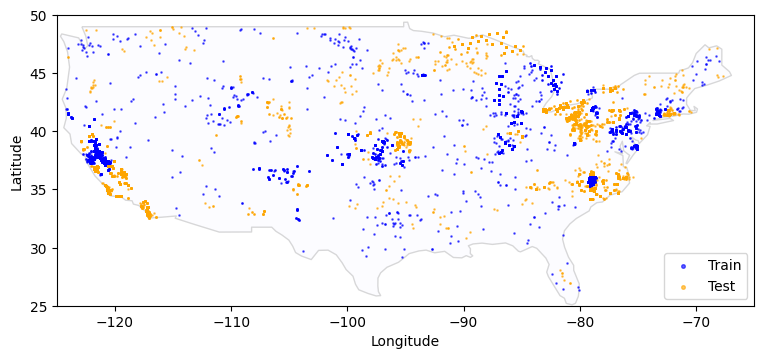

In [4]:
fig, ax = plt.subplots(figsize=(9, 4))

# map the training data
base = world[world.name == "United States of America"].plot(
    edgecolor="gray", color="ghostwhite", figsize=(9, 4), alpha=0.3, ax=ax
)
train_meta = metadata[metadata["split"] == "train"]
geometry = [Point(xy) for xy in zip(train_meta["longitude"], train_meta["latitude"])]
gdf = gpd.GeoDataFrame(train_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="blue", label="Train", alpha=0.6)

# map the test data
test_meta = metadata[metadata["split"] == "test"]
geometry = [Point(xy) for xy in zip(test_meta["longitude"], test_meta["latitude"])]
gdf = gpd.GeoDataFrame(test_meta, geometry=geometry)
gdf.plot(ax=base, marker=".", markersize=3, color="orange", label="Test", alpha=0.6)

plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.xlim([-125, -65])
plt.ylim([25, 50])
plt.legend(loc=4, markerscale=3)

In [5]:
# convert date to pd.datetime
metadata['date']= pd.to_datetime(metadata.date)

# what is the date range?
metadata.groupby("split").agg(min_date=("date", min), max_date=("date", max))

,min_date,max_date
split,,
test,2013-01-08,2021-12-29
train,2013-01-04,2021-12-14


In [6]:
metadata['uid'].nunique()

metadata.nunique()

uid          23570
latitude      8583
longitude    11167
date          1637
split            2
dtype: int64

Text(0.5, 1.0, 'Distribution of years in the data')

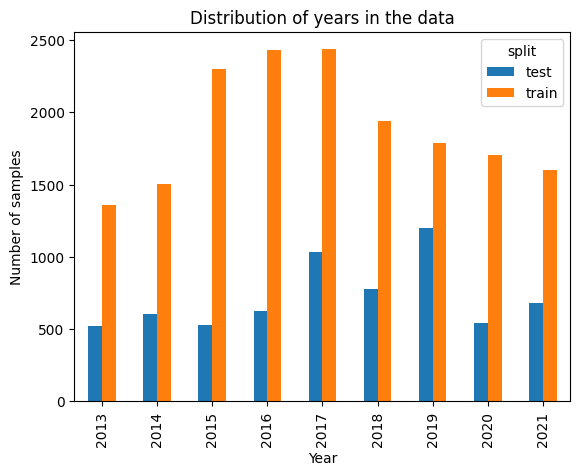

In [7]:
# what years are in the data?
pd.crosstab(metadata.date.dt.year, metadata.split).plot(kind="bar")
plt.ylabel("Number of samples")
plt.xlabel("Year")
plt.title("Distribution of years in the data")

In [8]:
# what seasons are the data points from?
metadata["season"] = (
    metadata.date.dt.month.replace([12, 1, 2], "winter")
    .replace([3, 4, 5], "spring")
    .replace([6, 7, 8], "summer")
    .replace([9, 10, 11], "fall")
)
metadata.season.value_counts()

summer    10813
spring     5045
fall       4758
winter     2954
Name: season, dtype: int64

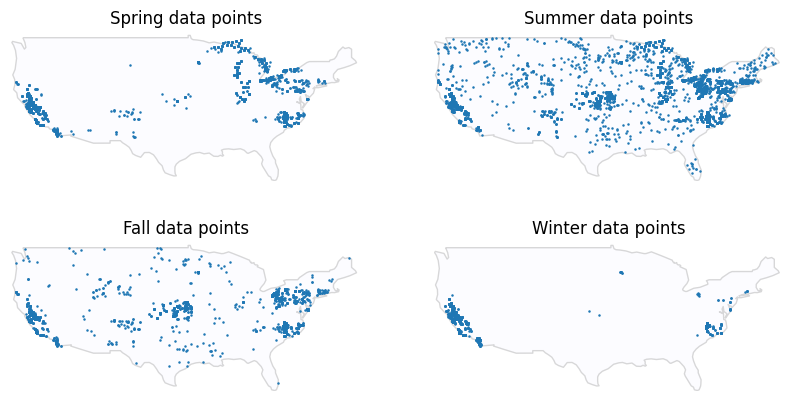

In [9]:
# where is data from for each season?
fig, axes = plt.subplots(2, 2, figsize=(10, 5))

for season, ax in zip(metadata.season.unique(), axes.flatten()):
    base = world[world.name == "United States of America"].plot(
        edgecolor="gray", color="ghostwhite", alpha=0.3, ax=ax
    )

    sub = metadata[metadata.season == season]
    geometry = [Point(xy) for xy in zip(sub["longitude"], sub["latitude"])]
    gdf = gpd.GeoDataFrame(sub, geometry=geometry)
    gdf.plot(ax=base, marker=".", markersize=2.5)
    ax.set_xlim([-125, -66])
    ax.set_ylim([25, 50])
    ax.set_title(f"{season.capitalize()} data points")
    ax.axis("off")

In [10]:
train_labels.head()

,uid,region,severity,density
0,aabm,midwest,1,585.0
1,aacd,south,1,290.0
2,aaee,south,1,1614.0
3,aaff,midwest,3,111825.0
4,aafl,midwest,4,2017313.0


In [11]:
train_labels_and_metadata = train_labels.merge(
    metadata, how="left", left_on="uid", right_on="uid", validate="1:1"
)

Text(0.5, 1.0, 'Train labels severity level counts')

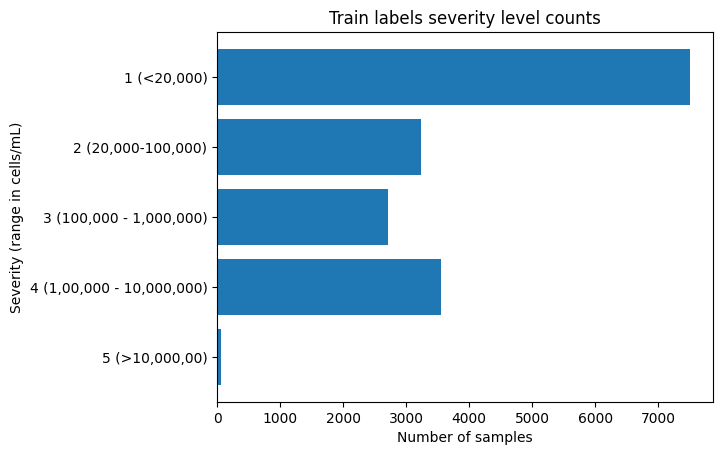

In [12]:
severity_counts = (
    train_labels.replace(
        {
            "severity": {
                1: "1 (<20,000)",
                2: "2 (20,000-100,000)",
                3: "3 (100,000 - 1,000,000)",
                4: "4 (1,00,000 - 10,000,000)",
                5: "5 (>10,000,00)",
            }
        }
    )
    .severity.value_counts()
    .sort_index(ascending=False)
)
plt.barh(severity_counts.index, severity_counts.values)
plt.xlabel("Number of samples")
plt.ylabel("Severity (range in cells/mL)")
plt.title("Train labels severity level counts")

## Our eda

### Look at seasonal patterns

In [13]:
train_labels_and_metadata.columns

Index(['uid', 'region', 'severity', 'density', 'latitude', 'longitude', 'date',
       'split', 'season'],
      dtype='object')

        severity       density   latitude  longitude
season                                              
fall    2.140225  1.175219e+06  37.122882 -88.124389
spring  2.142460  1.288114e+06  37.171905 -92.664731
summer  2.079021  7.665375e+05  37.610914 -87.269029
winter  2.412464  1.697516e+06  36.705350 -96.705477


[Text(0.5, 1.0, 'Cyanobacteria density per season')]

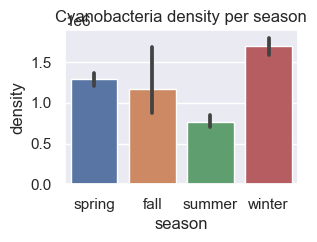

In [14]:
print(train_labels_and_metadata.groupby(train_labels_and_metadata.season).mean())
sns.set(rc={'figure.figsize':(3,2)})
sns.barplot(y=train_labels_and_metadata.density, x=train_labels_and_metadata.season).set(title='Cyanobacteria density per season')

Density seems to be highest in winter and lowest in summer --> surprising

           severity       density   latitude   longitude
region                                                  
midwest    2.194091  1.085957e+06  40.584320  -92.023762
northeast  1.805774  3.637635e+05  41.477473  -76.578711
south      1.567652  9.067514e+04  35.830916  -79.119300
west       3.747413  3.880252e+06  38.026713 -120.452401


[Text(0.5, 1.0, 'Cyanobacteria density per region')]

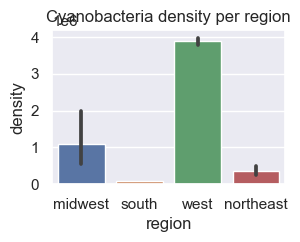

In [15]:
print(train_labels_and_metadata.groupby(train_labels_and_metadata.region).mean())
sns.set(rc={'figure.figsize':(3,2)})
sns.barplot(y=train_labels_and_metadata.density, x=train_labels_and_metadata.region).set(title='Cyanobacteria density per region')

Density is highest in west and lowest in south.

[Text(0.5, 1.0, 'Cyanobacteria density per season and region')]

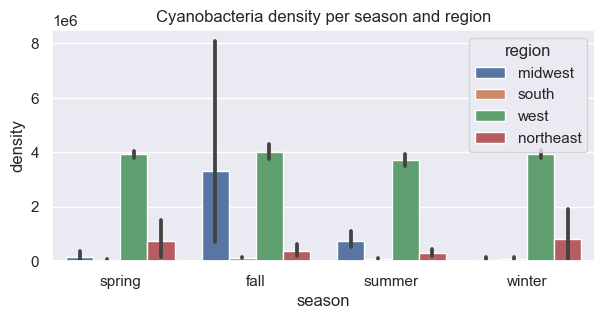

In [16]:
sns.set(rc={'figure.figsize':(7,3)})
sns.barplot(y=train_labels_and_metadata.density, x=train_labels_and_metadata.season, hue=train_labels_and_metadata.region).set(title='Cyanobacteria density per season and region')

Seasonal variation of the regions varies:

* west --> no seasonal changes
* midwest --> highest in fall (no winter measurments)
* south --> very low throughout the year
* northeast --> highest in winter and spring

[Text(0.5, 1.0, 'Samples taken per season and region')]

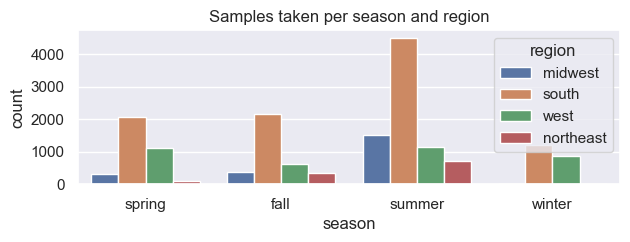

In [17]:
sns.set(rc={'figure.figsize':(7,2)})
sns.countplot(x=train_labels_and_metadata.season, hue=train_labels_and_metadata.region).set(title='Samples taken per season and region')


Most samples taken in south and west, in winter very few samples from northeast and midwest.


Text(0.5, 1.0, 'Cyanobacteria density across time')

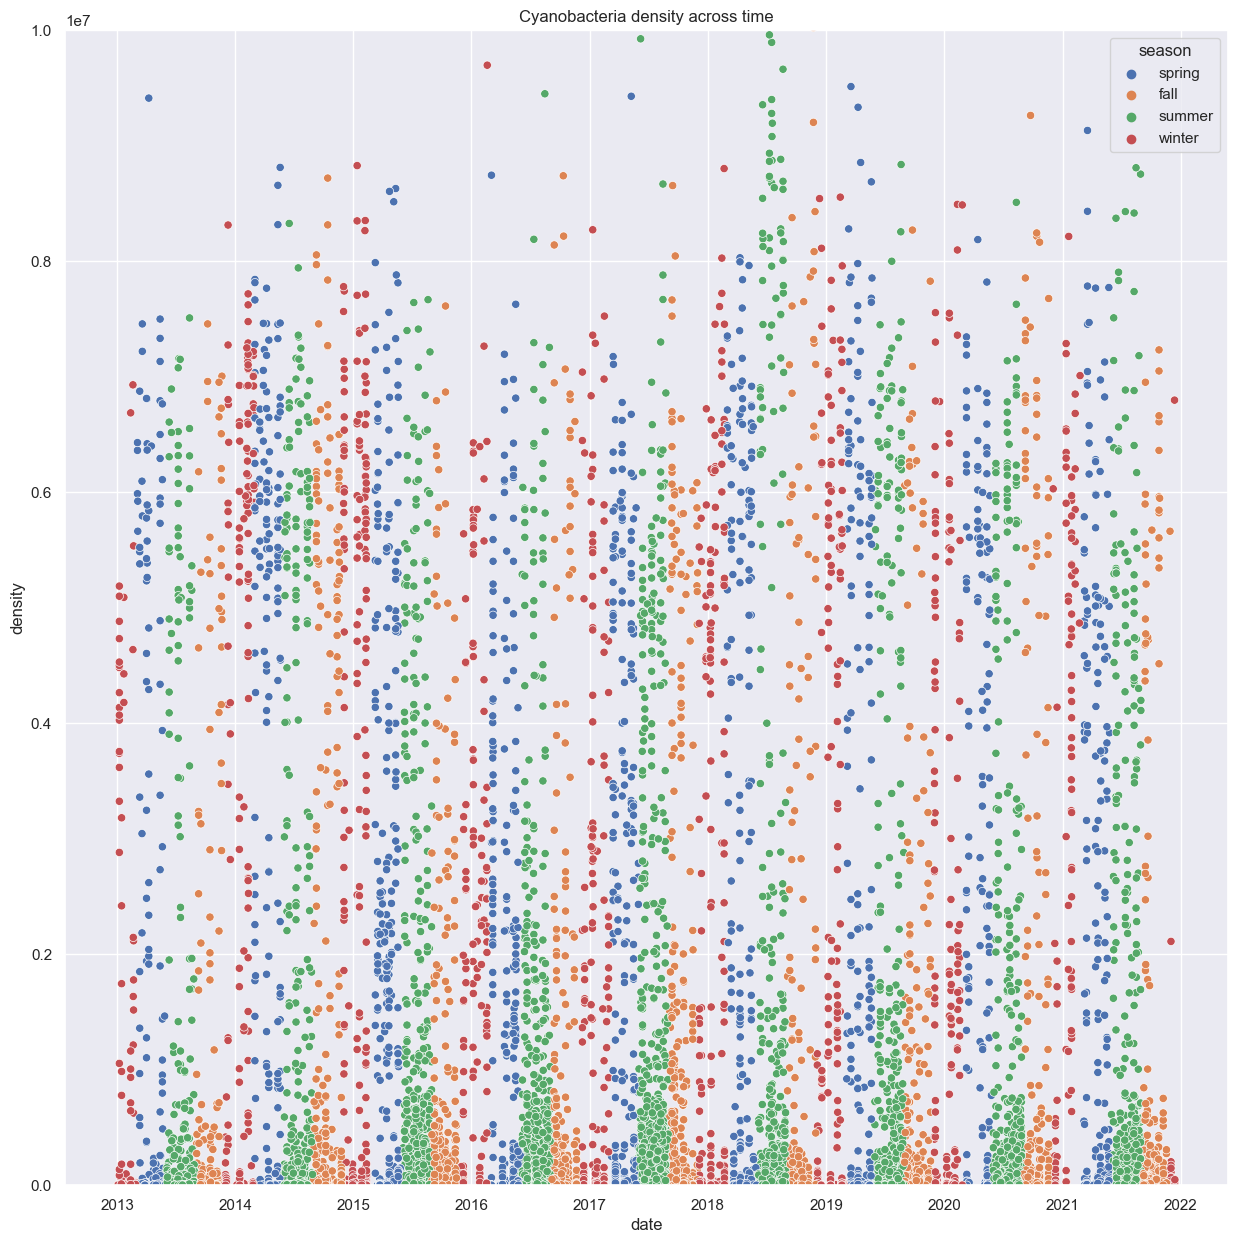

In [18]:
sns.set(rc={'figure.figsize':(15,15)})
#sns.scatterplot(x=train_labels_and_metadata.date[train_labels_and_metadata.region == 'south'], y=train_labels_and_metadata.density[train_labels_and_metadata.region == 'south'])
#sns.scatterplot(x=train_labels_and_metadata.date[train_labels_and_metadata.region == 'south'], y=train_labels_and_metadata.density[train_labels_and_metadata.region == 'south'], hue=train_labels_and_metadata.season)
sns.scatterplot(x=train_labels_and_metadata.date, y=train_labels_and_metadata.density, hue=train_labels_and_metadata.season)
plt.ylim(0, 1e7)
plt.title("Cyanobacteria density across time")


In [20]:
#were some locations sampled more than once?
#combine lat and long and then count how many entryies occure 1 time 
train_labels_and_metadata['lat_long'] = train_labels_and_metadata['latitude'].astype(str)+train_labels_and_metadata['longitude'].astype(str)
(train_labels_and_metadata.lat_long.value_counts()==1).value_counts()#count how many were sampled only one time -->10091 locations probably only sampled once


True     10091
False      523
Name: lat_long, dtype: int64

Text(0.5, 1.0, 'density over time with from frequently samples sites')

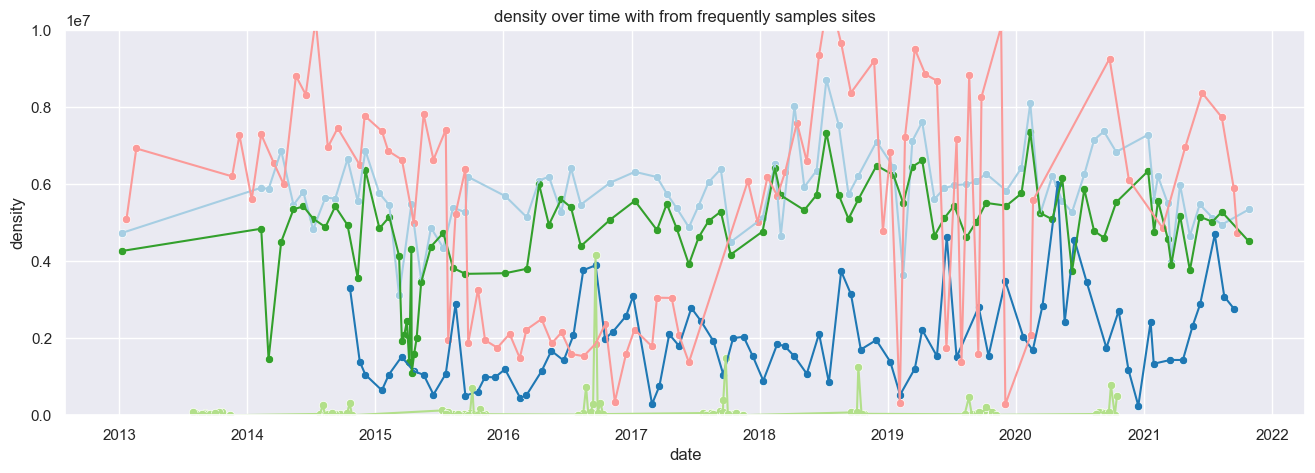

In [21]:
edaf.plot_multiples(train_labels_and_metadata,80)#plots all places sampled more than n times
plt.title('density over time with from frequently samples sites')